# This notebook contains training step and analysis using nmae result...

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, GenericUnivariateSelect
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

import xgboost as xgb

In [2]:
# Normalized Mean Absolute Error
def nmae(y_pred, y_test):
    mae = mean_absolute_error(y_test, y_pred)
    mean_true = np.mean(np.abs(y_test))
    return (mae / mean_true)

def normalized_mean_absolute_error(y_true, y_pred):
    """
    Calculates the Normalized Mean Absolute Error (NMAE).

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Estimated target values.

    Returns:
        float: The Normalized Mean Absolute Error.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length.")

    mae = np.mean(np.abs(y_true - y_pred))

    # Calculate the range of actual values
    y_range = np.max(y_true) - np.min(y_true)

    # Avoid division by zero if the range is zero
    if y_range == 0:
        return 0.0 if mae == 0 else np.inf
    else:
        nmae = mae / y_range
        return nmae

In [3]:
# Load write dataset
x_ds_t300 = pd.read_csv('datasets/exp90c_2h/t300/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_ds_t300.shape)
x_ds_t300.head(5)

(7803, 1864)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_blkio_device_usage_total_4,container_blkio_device_usage_total_5,container_blkio_device_usage_total_6,container_blkio_device_usage_total_7,container_blkio_device_usage_total_8,...,network_transmit_bytes_per_container_35,network_transmit_bytes_per_container_36,network_transmit_bytes_per_container_37,network_transmit_bytes_per_container_38,network_transmit_bytes_per_container_39,network_transmit_bytes_per_container_40,network_transmit_bytes_per_container_41,network_transmit_bytes_per_container_42,network_transmit_bytes_per_container_43,network_transmit_bytes_per_container_44
0,1762992952,917504,21835776,917504,18137088,3657728,23764992,3657728,17661952,2183168,...,11362.869198,0,37298.076923,0,8116.135740,0,45079.216354,0,0.000000,0.000000
1,1762992953,917504,21835776,917504,18137088,3657728,23764992,3657728,17661952,2183168,...,11362.869198,0,45641.408343,0,11930.740038,0,35540.387481,0,10524.707081,192749.617932
2,1762992954,917504,21835776,917504,18137088,3657728,23764992,3657728,17661952,2183168,...,12935.849057,0,44495.299910,0,13419.067947,0,33975.844378,0,13189.719896,439426.220040
3,1762992955,917504,21852160,917504,18137088,3657728,23764992,3657728,17661952,2183168,...,13514.304151,0,37464.678179,0,13651.031488,0,28949.745084,0,15515.018879,516895.442330
4,1762992956,917504,21852160,917504,18137088,3657728,23764992,3657728,17661952,2183168,...,12952.920962,0,34418.731988,0,13689.092097,0,42636.559140,0,11582.278481,385283.291139


In [4]:
y_ds_t300 = pd.read_csv('datasets/exp90c_2h/t300/20251113_001552902_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_ds_t300.shape)
y_ds_t300.head(5)

(7803, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
0,1762992952,0,0,0,0,0,0,0.000000,0.0,0.0,...,0,0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0
1,1762992953,9,0,0,0,6,2,0.059571,0.0,0.0,...,5,10,6.777778,1.715938,6.0,7.666667,10.00,10.0,10.0,10
2,1762992954,17,0,0,0,6,2,0.111783,0.0,0.0,...,5,10,6.312500,1.447699,6.0,7.000000,9.85,10.0,10.0,10
3,1762992955,24,0,0,0,5,2,0.156781,0.0,0.0,...,5,10,6.000000,1.285369,6.0,6.000000,9.45,10.0,10.0,10
4,1762992956,32,0,0,0,5,2,0.207684,0.0,0.0,...,5,10,5.870968,1.203936,6.0,6.000000,9.10,10.0,10.0,10


# KDE for write dataset metrics

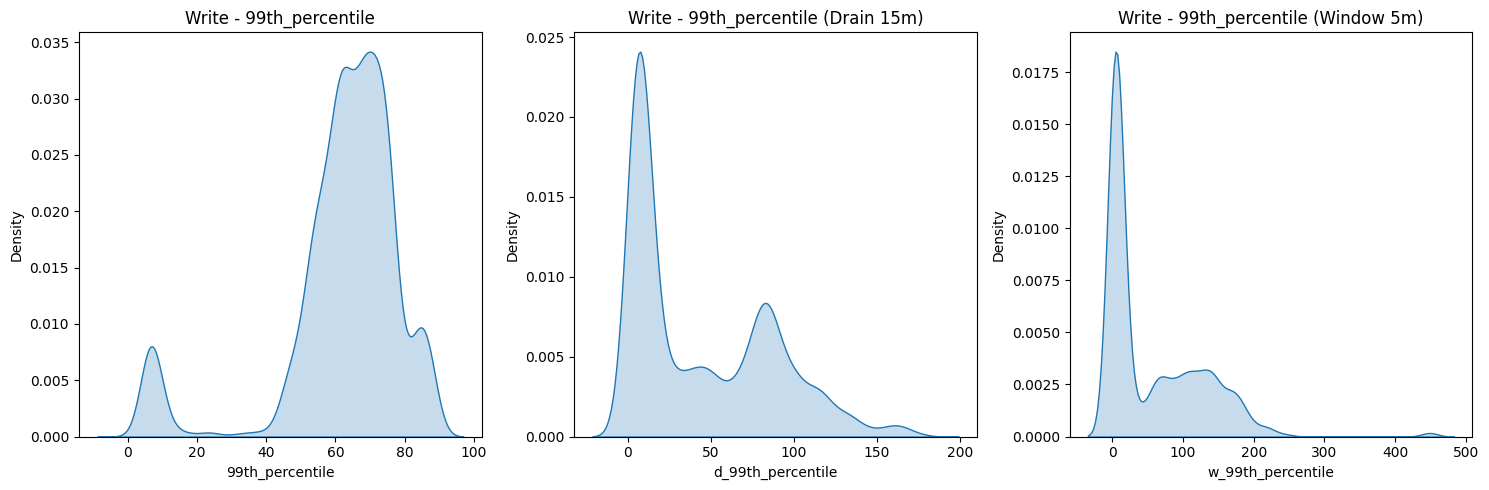

In [5]:
# 99th_percentile
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(y_ds_t300['99th_percentile'],fill=True, ax=axes[0])
axes[0].set_title("Write - 99th_percentile")

sns.kdeplot(y_ds_t300['d_99th_percentile'],fill=True, ax=axes[1])
axes[1].set_title("Write - 99th_percentile (Drain 15m)")

sns.kdeplot(y_ds_t300['w_99th_percentile'],fill=True, ax=axes[2])
axes[2].set_title("Write - 99th_percentile (Window 5m)")

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [6]:
# y_ds_t300_filtered = y_ds_t300.iloc[600:].copy()
# y_ds_t300_filtered.head()

y_ds_t300_filtered = y_ds_t300.copy()
y_ds_t300_filtered.head()

,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
0,1762992952,0,0,0,0,0,0,0.000000,0.0,0.0,...,0,0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0
1,1762992953,9,0,0,0,6,2,0.059571,0.0,0.0,...,5,10,6.777778,1.715938,6.0,7.666667,10.00,10.0,10.0,10
2,1762992954,17,0,0,0,6,2,0.111783,0.0,0.0,...,5,10,6.312500,1.447699,6.0,7.000000,9.85,10.0,10.0,10
3,1762992955,24,0,0,0,5,2,0.156781,0.0,0.0,...,5,10,6.000000,1.285369,6.0,6.000000,9.45,10.0,10.0,10
4,1762992956,32,0,0,0,5,2,0.207684,0.0,0.0,...,5,10,5.870968,1.203936,6.0,6.000000,9.10,10.0,10.0,10


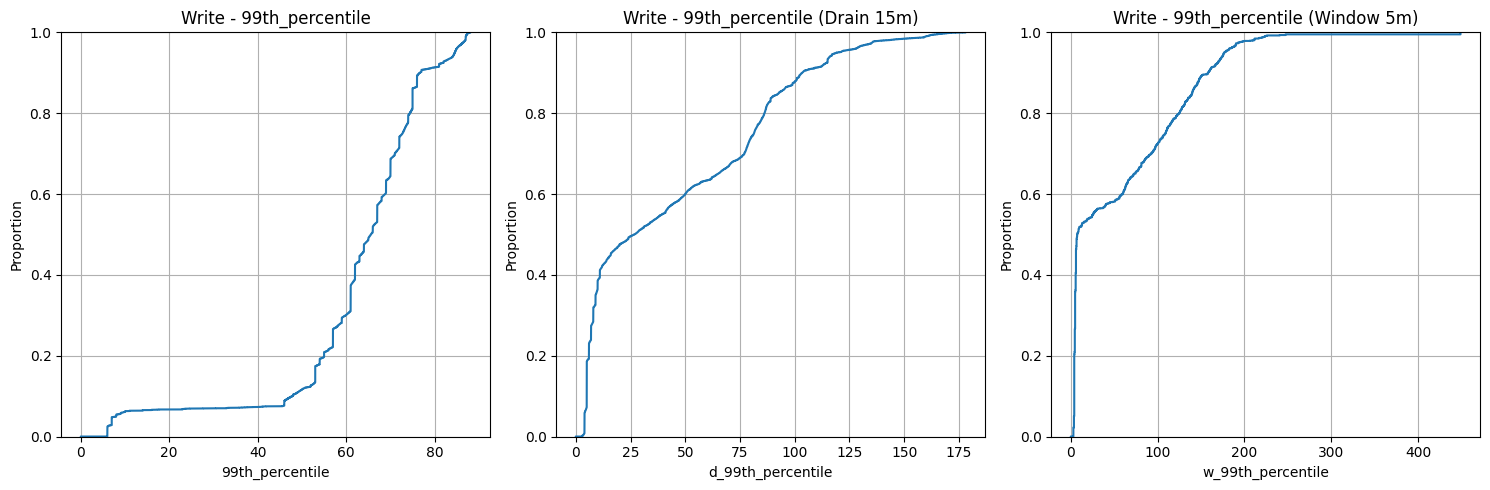

In [7]:
# 99th_percentile
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.ecdfplot(data=y_ds_t300_filtered, x='99th_percentile', ax=axes[0])
axes[0].set_title("Write - 99th_percentile")
axes[0].grid(True)

sns.ecdfplot(data=y_ds_t300_filtered, x='d_99th_percentile', ax=axes[1])
axes[1].set_title("Write - 99th_percentile (Drain 15m)")
axes[1].grid(True)

sns.ecdfplot(data=y_ds_t300_filtered, x='w_99th_percentile', ax=axes[2])
axes[2].set_title("Write - 99th_percentile (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [16]:
y_ds_t300_filtered = y_ds_t300[
    (y_ds_t300['w_99th_percentile'] > 100.00)
]
y_ds_t300_filtered.head()

,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
371,1762823027,2784,0,0,0,4,1,5.340906,7.488419,5.315691,...,2,898,14.950000,82.417938,2.0,3.0,5.0,255.70,556.7,898
372,1762823028,2792,0,0,0,4,1,5.346000,7.488419,5.315691,...,2,898,17.170000,84.752094,2.0,3.0,47.3,283.24,556.7,898
373,1762823029,2799,0,0,0,4,1,5.349161,7.488419,5.315691,...,2,898,17.180000,84.750357,2.0,3.0,47.3,283.24,556.7,898
374,1762823030,2806,0,0,0,4,1,5.354219,7.488419,5.315691,...,2,898,17.196667,84.747459,2.0,3.0,47.3,283.24,556.7,898
375,1762823031,2814,0,0,0,4,1,5.357349,7.481349,5.350142,...,2,898,17.200000,84.746879,2.0,3.0,47.3,283.24,556.7,898


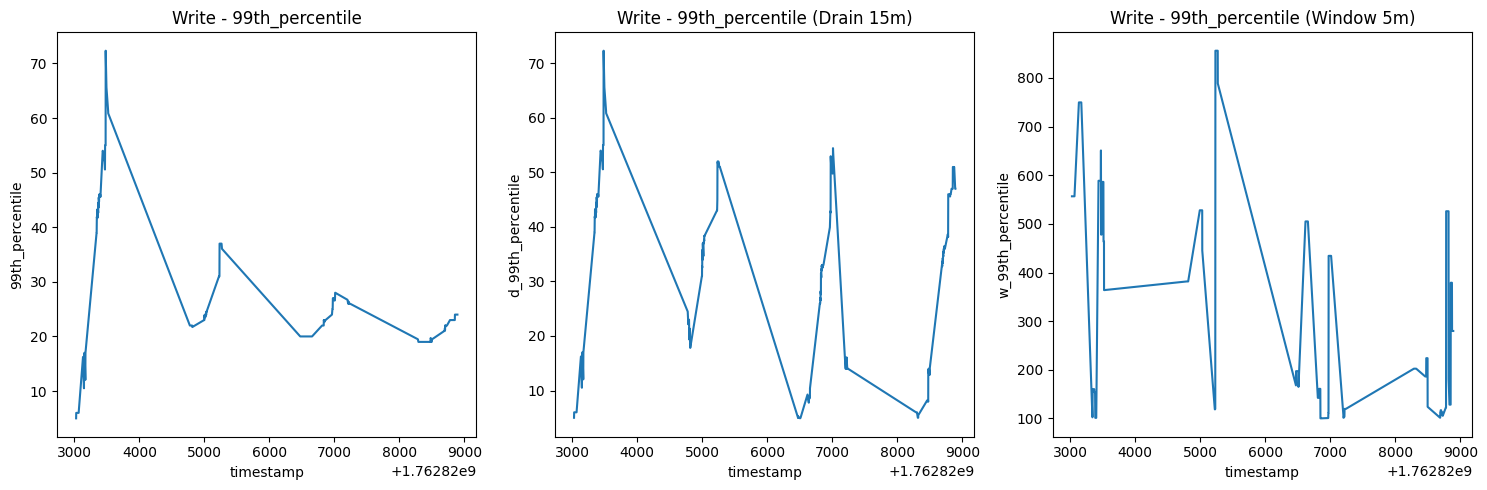

In [17]:
# 99th_percentile
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(x="timestamp", y="99th_percentile", data=y_ds_t300_filtered, ax=axes[0])
axes[0].set_title("Write - 99th_percentile")
# axes[0].grid(True)

sns.lineplot(x="timestamp", y="d_99th_percentile", data=y_ds_t300_filtered, ax=axes[1])
axes[1].set_title("Write - 99th_percentile (Drain 15m)")
# axes[1].grid(True)

sns.lineplot(x="timestamp", y="w_99th_percentile", data=y_ds_t300_filtered, ax=axes[2])
axes[2].set_title("Write - 99th_percentile (Window 5m)")
# axes[2].set_xlim(0.0, 50)
# axes[2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [6]:
def get_select_k_best_ds(x, y, k):
    selector = SelectKBest(f_regression, k=k)
    k_best_ds = selector.fit_transform(x, y)

    # Get a boolean mask of selected features
    selected_features_mask = selector.get_support()

    # Get the names of the selected features
    selected_feature_names = x.columns[selected_features_mask]
    print(selected_feature_names)

    k_best_ds = pd.DataFrame(k_best_ds, columns=selected_feature_names, index=x.index)
    print(k_best_ds.shape)
    k_best_ds.head(5)
    return k_best_ds

# Random Forest training using all features and k best features...

## train 70%, test 30%

## T300

In [8]:
# Full dataset - wihout normalization...

random_forest_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Rand. Forest Training time: 19.836947s
Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.20%
Rand. Forest Training time: 21.267906s
Full dataset | d_99th_percentile -> Rand. Forest NMAE: 2.60%
Rand. Forest Training time: 30.276783s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 12.79%


In [54]:
# Full dataset, using pipeline to normalize features and target.

# Define the feature pipeline
feature_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), # Normalize input features
])

rf_regressor = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)

# Combine with target scaling using TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('preprocess', feature_pipeline),
        ('model', rf_regressor)
    ]),
    transformer=MinMaxScaler()  # Normalizes the target y
)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Rand. Forest Training time: 30.79498s
Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.10%
Rand. Forest Training time: 52.514156s
Full dataset | d_99th_percentile -> Rand. Forest NMAE: 2.43%
Rand. Forest Training time: 73.947967s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 6.83%


In [55]:
# Full dataset, using xgboost

# 3. Initialize the XGBoost Regressor model
# objective='reg:squarederror' is the default for regression, but explicitly setting it is good practice.
# n_estimators controls the number of boosting rounds (trees).
# random_state for reproducibility.
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Rand. Forest Training time: 25.202146s
Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.09%
Rand. Forest Training time: 59.407267s
Full dataset | d_99th_percentile -> Rand. Forest NMAE: 3.09%
Rand. Forest Training time: 69.290943s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 5.87%
